In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator

In [15]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [16]:
from dgpy.domain import *
from dgpy.operators import *
from dgpy.utilities import build_matrix

## Define the DG scheme

In [51]:
def apply_first_order_poisson_operator(x, domain, penalty_parameter):
    domain.set_data(x, ['v', 'u'], fields_valence=(1, 0))
    for e in domain.elements:
        e.Au = -compute_div(e.v, e)
        e.grad_u = compute_deriv(e.u, e)
        e.Av = e.grad_u - e.v
        e.slice_to_faces('u', 'any')
        e.slice_to_faces('v', 'interior')
        e.slice_to_faces('grad_u', 'interior')
    for e in domain.elements:
        for face in e.get_interior_faces():
            sigma = penalty(face, penalty_parameter)
            e.Au -= compute_inverse_mass(lift_flux(
                face.normal_dot(face.average('grad_u') - face.v) - sigma * face.jump('u'),
                face
            ), e)
            e.Av += compute_inverse_mass(lift_flux(
                face.normal_times(face.average('u') - face.u),
                face
            ), e)
    return domain.get_data(['Av', 'Au'])

def compute_first_order_poisson_source(source_field, domain, dirichlet_boundary_field, penalty_parameter):
    for e in domain.elements:
        e.b_u = getattr(e, source_field)
        e.b_v = np.zeros((e.dim, *e.num_points))
        for face in e.get_external_faces():
            g = np.take(getattr(e, dirichlet_boundary_field), face.slice_index(), axis=face.dimension)
            sigma = penalty(face, penalty_parameter)
            e.b_u += compute_inverse_mass(lift_flux(
                2 * sigma * g,
                face
            ), e)
            e.b_v -= compute_inverse_mass(lift_flux(
                face.normal_times(g),
                face
            ), e)
    return domain.get_data(['b_v', 'b_u'])

class FirstOrderPoissonOperator(LinearOperator):
    def __init__(self, domain, penalty_parameter):
        self.domain = domain
        self.penalty_parameter = penalty_parameter
        N = domain.get_total_num_points() * (1 + domain.dim)
        super().__init__(shape=(N, N), dtype=np.float64)
    
    def _matvec(self, x):
        return apply_first_order_poisson_operator(x, self.domain, self.penalty_parameter)
    
    def compute_source(self, source_field, domain, dirichlet_boundary_field):
        return compute_first_order_poisson_source(source_field, domain, dirichlet_boundary_field, self.penalty_parameter)

## Construct a domain

In [118]:
domain = Domain(extents=1 * [(0, 2 * np.pi)], num_elements=3, num_points=3)

## Create the DG operator

In [119]:
A = FirstOrderPoissonOperator(domain=domain, penalty_parameter=1.)

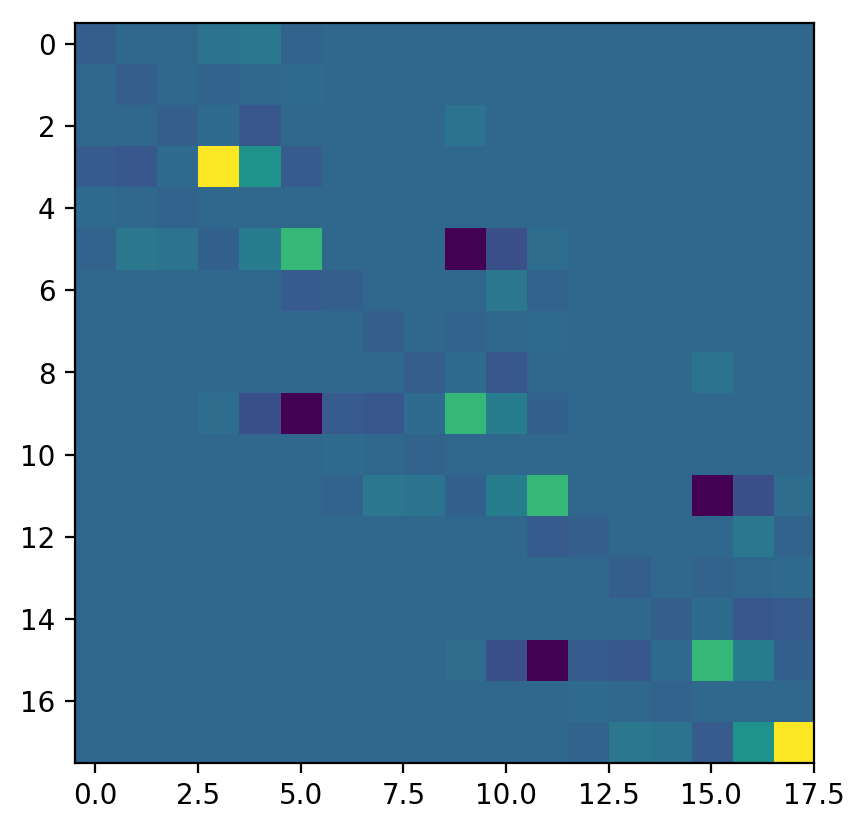

In [120]:
A_matrix = build_matrix(A)
plt.imshow(A_matrix)

## Choose a problem to solve

In [121]:
def phase(x, wave_numbers):
    return np.array([wave_numbers[d] * x[d] for d in range(len(x))])
def field(x, wave_numbers):
    return np.prod(np.sin(phase(x, wave_numbers)), axis=0)
def source(x, wave_numbers):
    return np.sum(np.asarray(wave_numbers)**2) * field(x, wave_numbers)

In [122]:
wave_numbers = [1] * domain.dim
domain.set_data(source, 'source', wave_numbers=wave_numbers)
domain.set_data(field, 'u_analytic', wave_numbers=wave_numbers)

## Solve the linear equations

In [123]:
from scipy.sparse.linalg import gmres

In [124]:
b = A.compute_source('source', domain, 'u_analytic')
sol, _ = gmres(A, b, tol=1e-8)
domain.set_data(sol, ['v_numeric', 'u_numeric'], fields_valence=(1, 0))

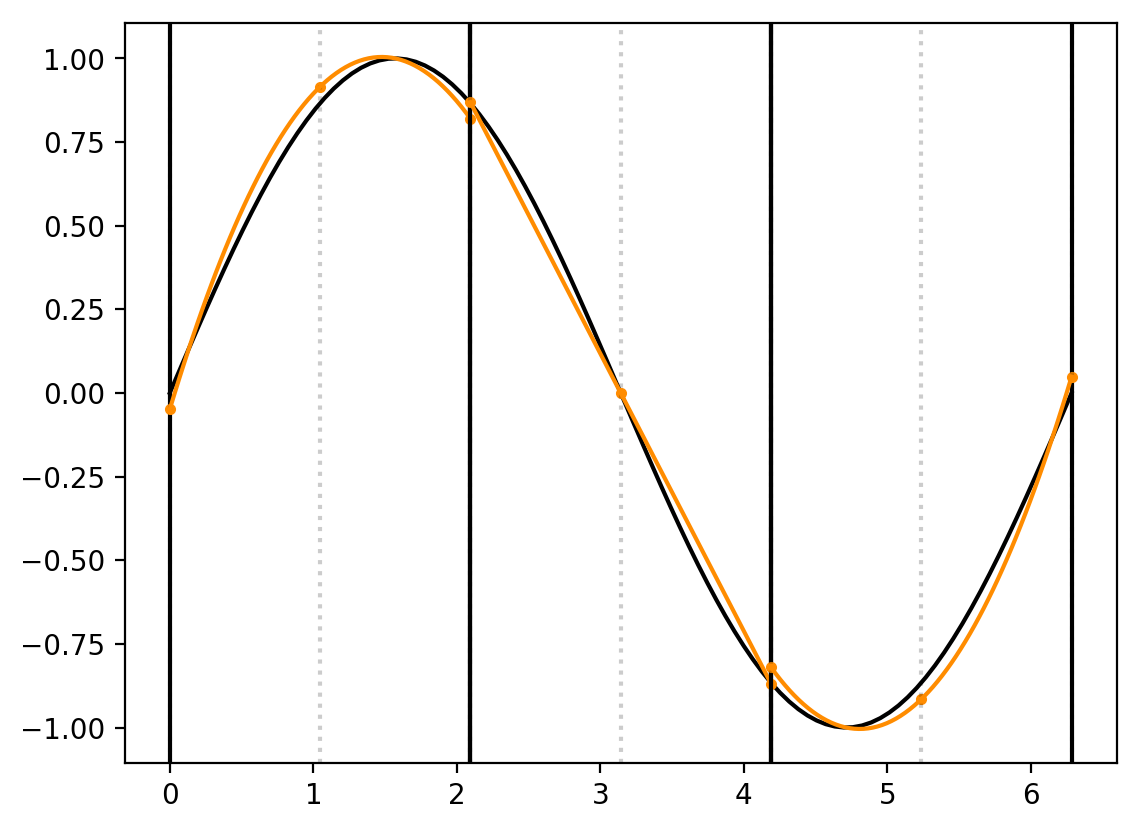

In [125]:
x_space = np.linspace(*domain.extents[0], 100)
plt.plot(x_space, field([x_space], wave_numbers), color='black')

domain.plot('u_numeric');